In [26]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,roc_auc_score,roc_curve
from sklearn.model_selection import cross_val_score,cross_val_predict ,GridSearchCV
from sklearn.ensemble import BaggingClassifier


In [27]:
#Get data

def get_data(data_csv_path:str): #https://pandas.pydata.org/pandas-docs/stable/reference/frame.html 
    df = pd.read_csv(data_csv_path)
    df.columns=["x"+str(i) for i in range(len(df.columns))]
    df.rename(columns = {list(df)[len(df.columns)-1]:'label'}, inplace=True)
    labels_list = []
    labels_df = df["label"]

    for label in labels_df:
        labels_list.append(label)

    labels = np.array(labels_list)

    df_without_labels = df.drop("label", axis=1)

    return df_without_labels, labels   

In [28]:
#Process data
def process_data():

    dataset1_X_train, dataset1_y_train = get_data("dataset1_training_data.csv")
    dataset1_X_test, dataset1_y_test = get_data("dataset1_testing_data.csv")

    dataset2_X_train, dataset2_y_train = get_data("dataset2_training_data.csv")
    dataset2_X_test, dataset2_y_test = get_data("dataset2_testing_data.csv")


    #create heatmap

    fig, ax =plt.subplots(ncols=2, figsize=(20, 8))
    ax[0].set_title('Correlation data 1', fontsize=30)
    ax[1].set_title('Correlation data 2', fontsize=30)

    sns.heatmap(dataset1_X_train.corr(), ax=ax[0])
    sns.heatmap(dataset2_X_train.corr(), ax=ax[1])

    plt.show()

    #Remove high correlated features from dataset (training and test)

    # Create correlation matrix
    corr_matrix_1 = dataset1_X_train.corr()
    
    corr_matrix_2 = dataset2_X_train.corr()

    # Select upper triangle of correlation matrix
    upper_1= corr_matrix_1.where(np.triu(np.ones(corr_matrix_1.shape), k=1).astype(np.bool_))
    
    upper_2= corr_matrix_2.where(np.triu(np.ones(corr_matrix_2.shape), k=1).astype(np.bool_))

    # Find index of feature columns with correlation greater than 0.95
    to_drop_1 = [column for column in upper_1.columns if any(upper_1[column] > 0.95)]
    
    to_drop_2 = [column for column in upper_2.columns if any(upper_2[column] > 0.95)]

    #new Data Frame without high correlated featues
    dataset1_X_train=dataset1_X_train.drop(dataset1_X_train[to_drop_1], axis=1)
    dataset1_X_test=dataset1_X_test.drop(dataset1_X_test[to_drop_1], axis=1)
    
    dataset2_X_train=dataset2_X_train.drop(dataset2_X_train[to_drop_2], axis=1)
    dataset2_X_test=dataset2_X_test.drop(dataset2_X_test[to_drop_2], axis=1) 
    
    return dataset1_X_train, dataset1_y_train, dataset1_X_test, dataset1_y_test, dataset2_X_train, dataset2_y_train, dataset2_X_test, dataset2_y_test    

In [29]:
def train_and_test_decision_tree( X_train, y_train, X_test, y_test):
    
    gsc = GridSearchCV(estimator=DecisionTreeClassifier(criterion='gini'),param_grid={'max_depth': range(3,8), 'min_samples_split': range(2,5),'min_samples_leaf': range(1,5)},cv=10, scoring='accuracy', verbose=0, n_jobs=-1)    
    grid_result = gsc.fit(X_train, y_train) #Results of the Decision Tree classifier with the optimize hyperparameters after 10-fold CV
    best_params = grid_result.best_params_ #Best paramerts
    best_score = grid_result.best_score_ #Score of the best model
    
    print("Best hyperparameters")
    print(best_params, '\n')
    
    print("Best score from CV")
    print(best_score, '\n')
    
    dt = DecisionTreeClassifier(criterion='gini',max_depth=best_params["max_depth"], random_state=0) #Create DT with optimal Hyperparameters

    model = dt.fit(X_train, y_train) 
    
    num_test_examples = len(X_test)
    num_test_labels = len(y_test)

    assert num_test_examples == num_test_labels
    
    predictions = []
    
    for test_example in X_test.iterrows(): #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iterrows.html#pandas.DataFrame.iterrows
        test_example_df = pd.DataFrame(test_example[1]).T #get each row of the df separately
        prediction = model.predict(test_example_df)[0]
        predictions.append(prediction)
    
    
    accuracy = accuracy_score(y_test, predictions)
    
    precision = precision_score(y_test, predictions)
    
    recall = recall_score(y_test, predictions)
    
    f1 = f1_score(y_test, predictions)
    
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    
    print('accuracy')
    print(accuracy, '\n')
    
    print('precision')
    print(precision, '\n')
    
    print('recall')
    print(recall, '\n')

    print('f1')
    print(f1, '\n')
    
    print('roc auc')
    print(roc_auc, '\n')
    
    return dt
    


In [30]:
#Boosting
def train_and_test_boosting(dt, X_train, y_train, X_test, y_test):
    
    bag_clf = BaggingClassifier(
    dt, n_estimators=500,
    max_samples=0.7, bootstrap=True, n_jobs=-1)  #Sampled with replecement. Each sample is 70% of the whole data. 500 DT trained
    
    bag_clf.fit(X_train, y_train)
    y_pred = bag_clf.predict(X_test)
    
    num_test_examples = len(X_test)
    num_test_labels = len(y_test)

    assert num_test_examples == num_test_labels
    
    predictions = []
    
    for test_example in X_test.iterrows(): #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iterrows.html#pandas.DataFrame.iterrows
        test_example_df = pd.DataFrame(test_example[1]).T #get each row of the df separately
        prediction = bag_clf.predict(test_example_df)[0]
        predictions.append(prediction)
       
    accuracy = accuracy_score(y_test, predictions)
    
    precision = precision_score(y_test, predictions)
    
    recall = recall_score(y_test, predictions)
    
    f1 = f1_score(y_test, predictions)
    
    roc_auc = roc_auc_score(y_test, bag_clf.predict_proba(X_test)[:, 1])

    print('Boosting \n')
    
    print('accuracy')
    print(accuracy, '\n')
    
    print('precision')
    print(precision, '\n')
    
    print('recall')
    print(recall, '\n')

    print('f1')
    print(f1, '\n')
    
    print('roc auc')
    print(roc_auc, '\n')


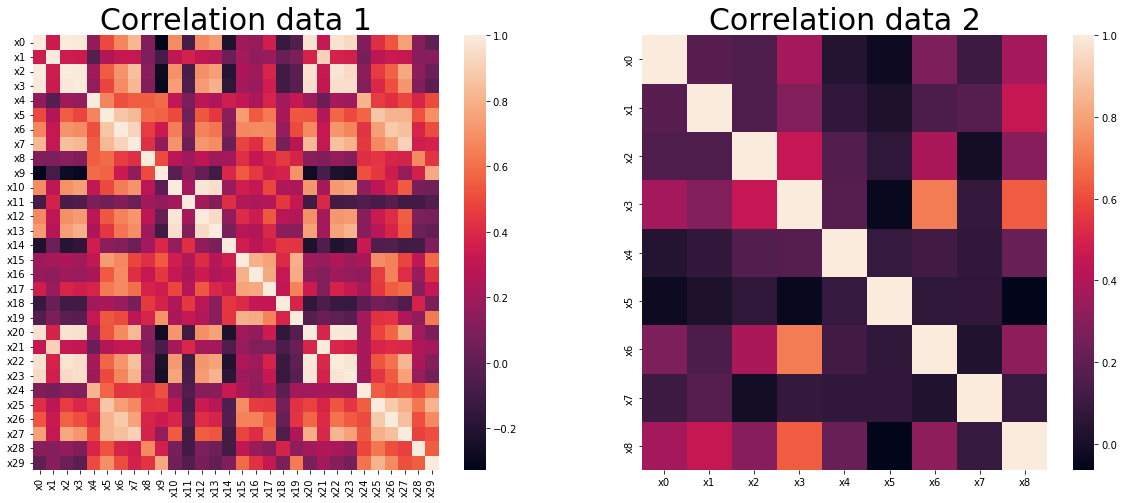

Best hyperparameters
{'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 4} 

Best score from CV
0.9471014492753623 

accuracy
0.9203539823008849 

precision
0.9428571428571428 

recall
0.825 

f1
0.88 

roc auc
0.8648972602739726 



In [31]:
#Running code
dataset1_X_train, dataset1_y_train, dataset1_X_test, dataset1_y_test, dataset2_X_train, dataset2_y_train, dataset2_X_test, dataset2_y_test = process_data()

dt = train_and_test_decision_tree( dataset1_X_train, dataset1_y_train, dataset1_X_test, dataset1_y_test)

In [32]:
train_and_test_boosting(dt, dataset1_X_train, dataset1_y_train, dataset1_X_test, dataset1_y_test)

Boosting 

accuracy
0.9469026548672567 

precision
0.9473684210526315 

recall
0.9 

f1
0.9230769230769231 

roc auc
0.9662671232876712 

